# Dissecting the VAE

A notebook for messing with the Oasis VAE... make sure you put the `vit-l-20.safetensors` into the `checkpoints/oasis` dir

In [9]:
device = "cuda"

In [33]:
import torch
from world_mar.oasis_utils.vae import AutoencoderKL
from omegaconf import OmegaConf
from world_mar.modules.utils import instantiate_from_config
from world_mar.dataset.dataloader import MinecraftDataModule

import matplotlib.pyplot as plt

In [24]:
cfg = OmegaConf.load("configs/world_mar.yaml")
world_mar = instantiate_from_config(cfg.model)
world_mar.to(device)
vae = world_mar.vae

In [ ]:
minecraft_dataloader = instantiate_from_config(cfg.dataloader).train_dataloader()

FINISHED PREPROCESSING ALL METADATA: 204.59852147102356


In [ ]:
latent_frame = minecraft_dataloader.train_dataset.__getitem__(100)

In [45]:
latents_pred = latent_frame["frames"][0].unsqueeze(0).to(device)
latents_pred.shape

torch.Size([1, 576, 16])

In [61]:
null_pred = 10 * torch.randn_like(latents_pred, device=device) + latents_pred

In [62]:
decoded = vae.decode(null_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.583302..1.5952659].


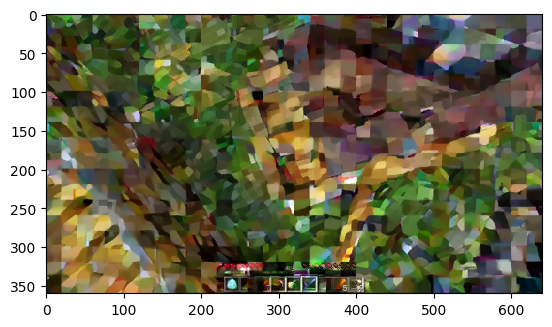

In [63]:
plt.imshow((((decoded[0] + 1) / 2)).permute(1,2,0).cpu())

## Latent Statistics

In [ ]:
mean_latent = torch.zeros(1, 576, 16, device=device)
max_avg = 0
for i, batch in enumerate(data):
    mean_latent += batch["frames"][:,0,:,:].to(device).mean(dim=0, keepdim=True)
    max_avg += batch["frames"].max().cpu().item()
    if i == 10:
        break
mean_latent = mean_latent / 10

In [73]:
max_avg / len(data)

0.06150337232956102

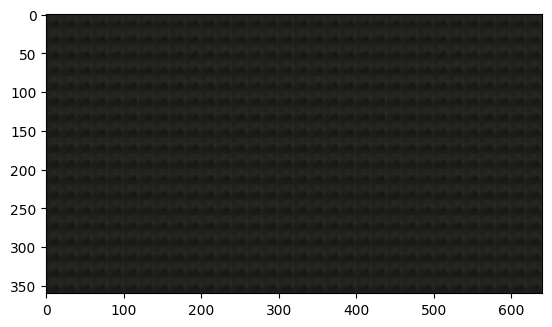

In [69]:
decoded_mean = vae.decode(mean_latent)
plt.imshow((((decoded_mean[0] + 1) / 2)).permute(1,2,0).cpu())